In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import datetime
import tqdm
import ast
import re

from scipy.stats import chi2_contingency
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from wordcloud import WordCloud

literal_eval = ast.literal_eval

# Data Analysis Notebook

## 1. Motivation 
- **What is your dataset?**

The dataset used in this paper is a subset of the Yelp dataset. Yelp is a widely used platform where users review businesses and businesses promote themselves. This subset of data contains several tables, with three used in the analysis: the business table, the review table, and the check-in table. The business table includes details such as the name, location (latitude and longitude), category (e.g., restaurant, shopping, clinic), and available services or amenities (e.g., wifi, TV, parking). From the review table, this paper uses the review text and reviewer-business mappings. Lastly, the check-in table provides timestamps for each instance a user "checked in" to a business.

- **Why did you choose this/these particular dataset(s)?**

It is no secret that COVID-19 affected businesses, causing some to close down while others managed to survive or even thrive. To understand what separated the survivors from the rest, we used this dataset because it contains real-world snapshot of business activity before, during, and after the COVID-19 pandemic. The data not only reflected business status but also included rich details about operations, customer interactions, and service offerings making it suited to study behavioral and operational shifts over time. 

- **What was your goal for the end user's experience?**

The goal is to understand the effect of covid has on businesses, and what are the factors that helped business survive. 

## 2. Basic stats. Let's understand the dataset better 
- **Write about your choices in data cleaning and preprocessing**

When loading the businesses as pandas data frame the categories and the attributes (which are written as json objects) are stored as string. First we convert categories from a string to lists of strings. Then we create a new data frame for attributes, where it stores each business's attributes as the correct type. then we load the reviews and check-ins.

The second block shows, how we filter the data through out the analysis.
- Filter businesses to only include those in Tampa and Philadelphia  
- Filter reviews and check-ins to only include those tied to the remaining businesses, and tag each with its city  
- Convert timestamps to proper `datetime` objects  
- Create a new dataframe for businesses categorized as Restaurants  
- Filter restaurant reviews to only include those made during the COVID period  
- Create two new dataframes: reviews and check-ins for open and closed restaurants active during COVID  
- Create a dataframe for businesses categorized under Shopping  
- Create two dataframes for attributes of open and closed restaurants  


In [2]:
# Load ALL businesses
BUSINESSES = pd.read_json("../data/yelp_academic_dataset_business.json", lines=True, engine="pyarrow")
# Dealing with Category
cat_freq =dict()
def get_categories(categories):
    categories = [cat.strip() for cat in categories.strip().split(',')]
    quoted_cats = [f'"{cat}"' for cat in categories]
    quoted_cats = '[' + ', '.join(quoted_cats) + ']'
    return quoted_cats
BUSINESSES = BUSINESSES.dropna(subset=['categories']).copy()
BUSINESSES['categories'] = BUSINESSES['categories'].apply(get_categories).apply(literal_eval)

cat_freq = {}
for ls in BUSINESSES['categories']:
    for cat in ls:
        cat_freq[cat] = cat_freq.get(cat, 0) + 1

# creating an attributes dataframe 
attribute_ls = list(BUSINESSES.iloc[0]['attributes'].keys())
attribute_freq = dict.fromkeys(attribute_ls, 0)
attribute_df = pd.DataFrame(columns=["business_id"]+attribute_ls)

rows = []

for _, row in tqdm.tqdm(BUSINESSES.iterrows(), total=BUSINESSES.shape[0]):
    id = row['business_id']
    attributes = row['attributes']
    
    new_row = [id] + [None] * len(attribute_ls)
    if isinstance(attributes, dict):
        for i, attr in enumerate(attribute_ls):
            value = attributes.get(attr)
            if value is not None:
                attribute_freq[attr] += 1
                try:
                    new_row[i + 1] = literal_eval(value)
                except:
                    new_row[i + 1] = value
                    print(f"Failed to parse {attr}: {value}, type: {type(value)}")

    rows.append(new_row)

attribute_df = pd.DataFrame(rows, columns=["business_id"] + attribute_ls)

# Loading All reviews
reviews = pd.read_json("../data/yelp_academic_dataset_review.json", lines=True,engine = "pyarrow")
reviews['date'] = pd.to_datetime(reviews['date'])
checkins = pd.read_json("../data/yelp_academic_dataset_checkin.json", lines=True, engine="pyarrow")



100%|██████████| 150243/150243 [00:15<00:00, 9988.36it/s] 


In [3]:
# FILTERING STUFF
# Filter out businesses not in tampa and philadelphia
red_city = "Tampa"
blue_city = "Philadelphia"
businesses = BUSINESSES.copy()
businesses = businesses[businesses['city'].isin([red_city, blue_city])]

# Get the business ids for the two cities
red_business_ids = set(businesses[businesses['city'] == red_city]['business_id'])
blue_business_ids = set(businesses[businesses['city'] == blue_city]['business_id'])

# Filter reviews to only include those for businesses in the two cities
reviews = reviews[reviews['business_id'].isin(red_business_ids | blue_business_ids)]
checkins = checkins[checkins['business_id'].isin(red_business_ids | blue_business_ids)]
# Label the reviews with the city of the business
reviews.loc[reviews['business_id'].isin(red_business_ids), 'city'] = red_city
reviews.loc[reviews['business_id'].isin(blue_business_ids), 'city'] = blue_city

checkins.loc[checkins['business_id'].isin(red_business_ids), 'city'] = red_city
checkins.loc[checkins['business_id'].isin(blue_business_ids), 'city'] = blue_city   

# Fix date time format for both
checkins['date_list'] = None
checkins['date_list'] = checkins['date'].apply(lambda x: [datetime.datetime.strptime(date.strip(), "%Y-%m-%d %H:%M:%S") 
                                                         for date in x.split(',')])
reviews['date'] = pd.to_datetime(reviews['date'])

# Create a restaurant dataframe
restaurants = businesses[businesses['categories'].apply(lambda x: 'Restaurants' in x)]
restaurant_ids = restaurants['business_id'].tolist()

# filter reviews and checkins to only include those for restaurants operational during the pandemic
before_date = datetime.datetime(2020, 12, 30)
after_date = datetime.datetime(2020, 3, 1)


restaurants_reviews = reviews[reviews['business_id'].isin(restaurant_ids)]
covid_restaurants_reviews =restaurants_reviews[(reviews['date'] < before_date) &
                                                (reviews['date'] > after_date)  ]
covid_restaurants_checkins = checkins[checkins['business_id'].isin(restaurant_ids)]

checkin_ids = set()
for _, row in covid_restaurants_checkins.iterrows():
    # Check if any date in the list is after Jan 1, 2019
    if any((date < before_date) and (date > after_date) for date in row['date_list']):
        checkin_ids.add(row['business_id'])
covid_restaurants_checkins = covid_restaurants_checkins[covid_restaurants_checkins['business_id'].isin(checkin_ids)]

# Filter restaurants to only include those operational during the pandemic
restaurants_in_covid = restaurants[restaurants['business_id'].isin(restaurants_reviews['business_id'].tolist()+list(checkin_ids))]
open_restaurants = restaurants_in_covid[restaurants_in_covid['is_open'] == 1]
closed_restaurants = restaurants_in_covid[restaurants_in_covid['is_open'] == 0]

closed_reviews = covid_restaurants_reviews[covid_restaurants_reviews['business_id'].isin(closed_restaurants['business_id'].tolist())]
closed_checkins = checkins[checkins['business_id'].isin(closed_restaurants['business_id'].tolist())]

open_reviews = covid_restaurants_reviews[covid_restaurants_reviews['business_id'].isin(open_restaurants['business_id'].tolist())]
open_checkins = checkins[checkins['business_id'].isin(open_restaurants['business_id'].tolist())]


# create a shopping dataframe
shopping = businesses[businesses['categories'].apply(lambda x: 'Shopping' in x)]
shopping_ids = shopping['business_id'].tolist()

# Open and closed restaurants attributes
open_attributes = attribute_df[attribute_df['business_id'].isin(open_restaurants['business_id'].tolist())].copy()
closed_attributes = attribute_df[attribute_df['business_id'].isin(closed_restaurants['business_id'].tolist())].copy()


C:\Users\musti\AppData\Local\Temp\ipykernel_30876\2716570951.py:38: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  covid_restaurants_reviews =restaurants_reviews[(reviews['date'] < before_date) &


- **Write a short section that discusses the dataset stats, containing key points/plots from your exploratory data analysis.**

In total there are around 150,000 businesses and around 7 million reviews. Narrowing the scope to the two cities, we get around 235,000 business and 1,422,328 reviews. Narrowing down even further, number of restaurants operational during the pandemic in both cities is 8812 and they have 44,495 reviews. 5489 of these restaurant we consider to be still open, while 3323 of them closed during covid.  

The average review rating across all reviews is 3.77, with Philadelphia slightly higher at 3.78, and Tampa at 3.75. For restaurants operational during the pandemic, the average review rating is notably higher at 3.96. Looking within cities, pandemic-era restaurants in Philadelphia average 3.81, while Tampa's average is 3.84.

Review frequency is highly skewed:  
- The average number of reviews per business is 60.26, while the median is much lower at 18, showing heavy-tailed behavior.  
- For pandemic restaurants, the average is just 9.36, with a median of 5.  
- The maximum number of reviews for a single business is 5,778.  
- Median reviews per business: Philadelphia: 20, Tampa: 16.  
- Average reviews per restaurant: Philadelphia: 117.45, Tampa: 102.44.

These distributions show a concentration of activity among a small number of businesses, and reinforce the need to treat review counts carefully in any comparative analysis.



Back to looking at all businesses, we also analyzed the business categories present in the dataset. There are 1,311 unique categories, with a median of 66 businesses per category and a mean of approximately 510. The most populated category is *Restaurants*, containing over 52,000 businesses. In total, 125 categories have more than 1,000 businesses, reflecting a highly skewed distribution.

The top 50 most common categories include general sectors like *Food*, *Shopping*, *Beauty & Spas*, and more specific cuisines and services such as *Pizza*, *Hair Salons*, *Mexican*, *Real Estate*, and *Cafes*.


Attribute data is available for all businesses, covering 39 distinct attributes. The most common attribute is *BusinessAcceptsCreditCards*, present in nearly 120,000 businesses. On average, each attribute is available for around 30,944 businesses, with a median of 28,953.

The top attributes include practical and service-related features such as *BusinessParking*, *RestaurantsPriceRange2*, *BikeParking*, *RestaurantsTakeOut*, and *WiFi*. This confirms that many businesses include basic customer experience and logistical information in their profiles.

In [4]:
print("====  BUSINESSES ====")
print(BUSINESSES.columns)
print("number of businesses: ", BUSINESSES.shape[0])
print("number of citys: ", BUSINESSES['city'].nunique())
print("number of states: ", BUSINESSES['state'].nunique())
print("number of categories: ", len(cat_freq))
freq_city = BUSINESSES['city'].value_counts()

print("number of businesses in Philadelphia: ", len(BUSINESSES[BUSINESSES['city'] == blue_city]))
print("number of businesses in Tampa: ", len(BUSINESSES[BUSINESSES['city'] == red_city]))

print("Number of restaurants in Philadelphia: ", len(restaurants[restaurants['city'] == blue_city]))
print("Number of restaurants in Tampa: ", len(restaurants[restaurants['city'] == red_city]))
print("Number of restaurants operational during the pandemic: ", len(restaurants_in_covid))
print("Number of restaurants operational during the pandemic in Philadelphia: ", len(restaurants_in_covid[restaurants_in_covid['city'] == blue_city]))
print("Number of restaurants operational during the pandemic in Tampa: ", len(restaurants_in_covid[restaurants_in_covid['city'] == red_city]))
print("Number of restaurants that are open: ", len(open_restaurants))
print("Number of restaurants that are closed: ", len(closed_restaurants))



print("====  REVIEWS ====")
print(reviews.columns)
print("number of reviews: ", reviews.shape[0])
print("number of reviews in Philadelphia: ", len(reviews[reviews['city'] == blue_city]))
print("number of reviews in Tampa: ", len(reviews[reviews['city'] == red_city]))
print("number of reviews in restaurants: ", len(restaurants_reviews))
print("number of reviews in restaurants in Philadelphia: ", len(restaurants_reviews[restaurants_reviews['city'] == blue_city]))
print("number of reviews in restaurants in Tampa: ", len(restaurants_reviews[restaurants_reviews['city'] == red_city]))
print("number of reviews in restaurants operational during the pandemic: ", len(covid_restaurants_reviews))

print("====== stats ======")
print("mean review stars: ", reviews['stars'].mean())
print("mean review stars in Philadelphia: ", reviews[reviews['city'] == blue_city]['stars'].mean())
print("mean review stars in Tampa: ", reviews[reviews['city'] == red_city]['stars'].mean())
print("mean review stars in restaurants operational during the pandemic: ", covid_restaurants_reviews['stars'].mean())
print("mean review stars in restaurants in Philadelphia: ", restaurants_reviews[restaurants_reviews['city'] == blue_city]['stars'].mean())
print("mean review stars in restaurants in Tampa: ", restaurants_reviews[restaurants_reviews['city'] == red_city]['stars'].mean())

print("Average number of reviews per business: ", reviews.groupby('business_id')['review_id'].count().mean())
print("Average number of reviews per business in Philadelphia: ", reviews[reviews['city'] == blue_city].groupby('business_id')['review_id'].count().mean())
print("Average number of reviews per business in Tampa: ", reviews[reviews['city'] == red_city].groupby('business_id')['review_id'].count().mean())
print("Average number of reviews per business in restaurants operational during the pandemic: ", covid_restaurants_reviews.groupby('business_id')['review_id'].count().mean())
print("Average number of reviews per business in restaurants in Philadelphia: ", restaurants_reviews[restaurants_reviews['city'] == blue_city].groupby('business_id')['review_id'].count().mean())
print("Average number of reviews per business in restaurants in Tampa: ", restaurants_reviews[restaurants_reviews['city'] == red_city].groupby('business_id')['review_id'].count().mean())

print("maximum number of reviews per business: ", reviews.groupby('business_id')['review_id'].count().max())
print("median number of reviews per business: ", reviews.groupby('business_id')['review_id'].count().median())
print("median number of reviews per business in restaurants operational during the pandemic: ", covid_restaurants_reviews.groupby('business_id')['review_id'].count().median())
print("median number of reviews per business in Philadelphia: ", reviews[reviews['city'] == blue_city].groupby('business_id')['review_id'].count().median())
print("median number of reviews per business in Tampa: ", reviews[reviews['city'] == red_city].groupby('business_id')['review_id'].count().median())

print("=========================================")


====  BUSINESSES ====
Index(['business_id', 'name', 'address', 'city', 'state', 'postal_code',
       'latitude', 'longitude', 'stars', 'review_count', 'is_open',
       'attributes', 'categories', 'hours'],
      dtype='object')
number of businesses:  150243
number of citys:  1415
number of states:  27
number of categories:  1311
number of businesses in Philadelphia:  14560
number of businesses in Tampa:  9042
Number of restaurants in Philadelphia:  5852
Number of restaurants in Tampa:  2960
Number of restaurants operational during the pandemic:  8812
Number of restaurants operational during the pandemic in Philadelphia:  5852
Number of restaurants operational during the pandemic in Tampa:  2960
Number of restaurants that are open:  5489
Number of restaurants that are closed:  3323
====  REVIEWS ====
Index(['review_id', 'user_id', 'business_id', 'stars', 'useful', 'funny',
       'cool', 'text', 'date', 'city'],
      dtype='object')
number of reviews:  1422328
number of reviews in Ph

### The basic plots

The following plot will show the number of business per state, moreover, the second plot will show which cities has the highest business count. Keep in mind that the data is subset of the whole yelp dataset, it contains 11 metropolitan areas. Since most data are in Tampa and Philadelphia.   

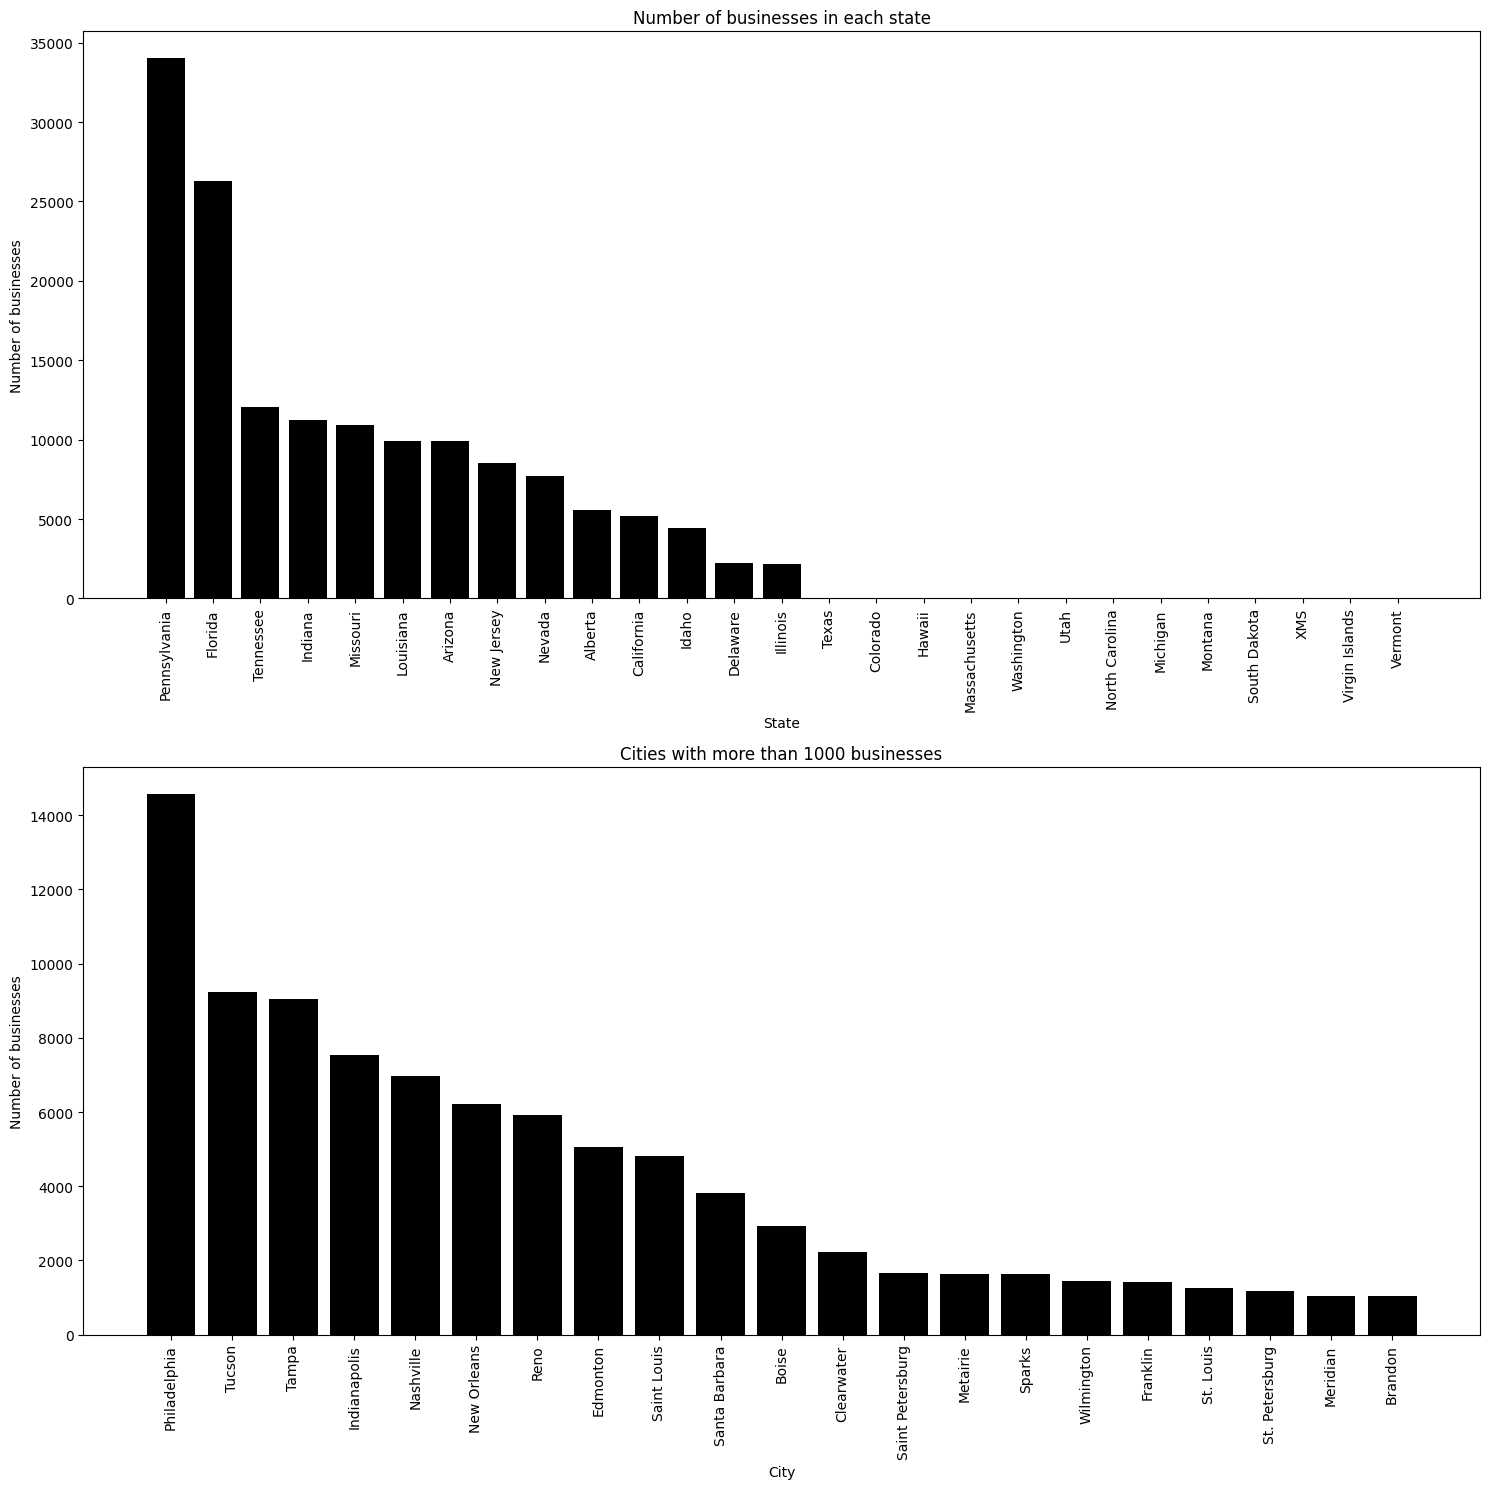

In [23]:
state_name_map = {
    'AK': 'Alaska',        'AL': 'Alabama',       'AR': 'Arkansas',      'AS': 'American Samoa', 'AZ': 'Arizona',       'CA': 'California',
    'CO': 'Colorado',      'CT': 'Connecticut',   'DC': 'District of Columbia', 'DE': 'Delaware', 'FL': 'Florida',      'FM': 'Federated States of Micronesia',
    'GA': 'Georgia',       'GU': 'Guam',          'HI': 'Hawaii',        'IA': 'Iowa',           'ID': 'Idaho',         'IL': 'Illinois',
    'IN': 'Indiana',       'KS': 'Kansas',        'KY': 'Kentucky',      'LA': 'Louisiana',      'MA': 'Massachusetts', 'MD': 'Maryland',
    'ME': 'Maine',         'MH': 'Marshall Islands', 'MI': 'Michigan',   'MN': 'Minnesota',      'MO': 'Missouri',      'MP': 'Northern Mariana Islands',
    'MS': 'Mississippi',   'MT': 'Montana',       'NC': 'North Carolina', 'ND': 'North Dakota',  'NE': 'Nebraska',      'NH': 'New Hampshire',
    'NJ': 'New Jersey',    'NM': 'New Mexico',    'NV': 'Nevada',        'NY': 'New York',       'OH': 'Ohio',          'OK': 'Oklahoma',
    'OR': 'Oregon',        'PA': 'Pennsylvania',  'PR': 'Puerto Rico',   'PW': 'Palau',          'RI': 'Rhode Island',  'SC': 'South Carolina',
    'SD': 'South Dakota',  'TN': 'Tennessee',     'TX': 'Texas',         'UT': 'Utah',           'VA': 'Virginia',      'VI': 'Virgin Islands',
    'VT': 'Vermont',       'WA': 'Washington',    'WI': 'Wisconsin',     'WV': 'West Virginia',  'WY': 'Wyoming', 
    "AB": 'Alberta'
}
freq_state = BUSINESSES['state'].value_counts()
mapped_states = [state_name_map.get(state, state) for state in freq_state.index]

fig,ax = plt.subplots(2, 1, figsize=(15, 15))
# First subplot - States
ax[0].bar(mapped_states, freq_state.values,color='Black')
ax[0].set_title("Number of businesses in each state")
ax[0].set_xlabel("State")
ax[0].set_ylabel("Number of businesses")
plt.setp(ax[0].get_xticklabels(), rotation=90)  # Rotate xticks

ax[1].bar(freq_city.index[freq_city > 1000], freq_city.values[freq_city > 1000],color='Black')
ax[1].set_title("Cities with more than 1000 businesses")
ax[1].set_xlabel("City")
ax[1].set_ylabel("Number of businesses")
plt.setp(ax[1].get_xticklabels(), rotation=90)  # Rotate xticks
plt.grid(False)
plt.tight_layout()


Here we plot the count of business categories, where each business can have multiple categories. Moreover, looking at some of the top categories, it can be said that there is high overlap between some of these categories. Furthermore, when we state a business is a "restaurant" it means that it has the "Restaurants" category.   

number of categories:  1311
mean number of business in a category:  509.9862700228833
median number of business in a category:  66.0
max number of business in a category:  52268
max category:  Restaurants
number of categories with more than 1000 business:  125
the top 50 categories:  ['Restaurants', 'Food', 'Shopping', 'Home Services', 'Beauty & Spas', 'Nightlife', 'Health & Medical', 'Local Services', 'Bars', 'Automotive', 'Event Planning & Services', 'Sandwiches', 'American (Traditional)', 'Active Life', 'Pizza', 'Coffee & Tea', 'Fast Food', 'Breakfast & Brunch', 'American (New)', 'Hotels & Travel', 'Home & Garden', 'Fashion', 'Burgers', 'Arts & Entertainment', 'Auto Repair', 'Hair Salons', 'Nail Salons', 'Mexican', 'Italian', 'Specialty Food', 'Doctors', 'Pets', 'Real Estate', 'Seafood', 'Fitness & Instruction', 'Professional Services', 'Hair Removal', 'Desserts', 'Chinese', 'Bakeries', 'Grocery', 'Salad', 'Hotels', 'Chicken Wings', 'Cafes', 'Ice Cream & Frozen Yogurt', 'Caterers', 

Text(0.5, 1.0, 'Top 50 categories')

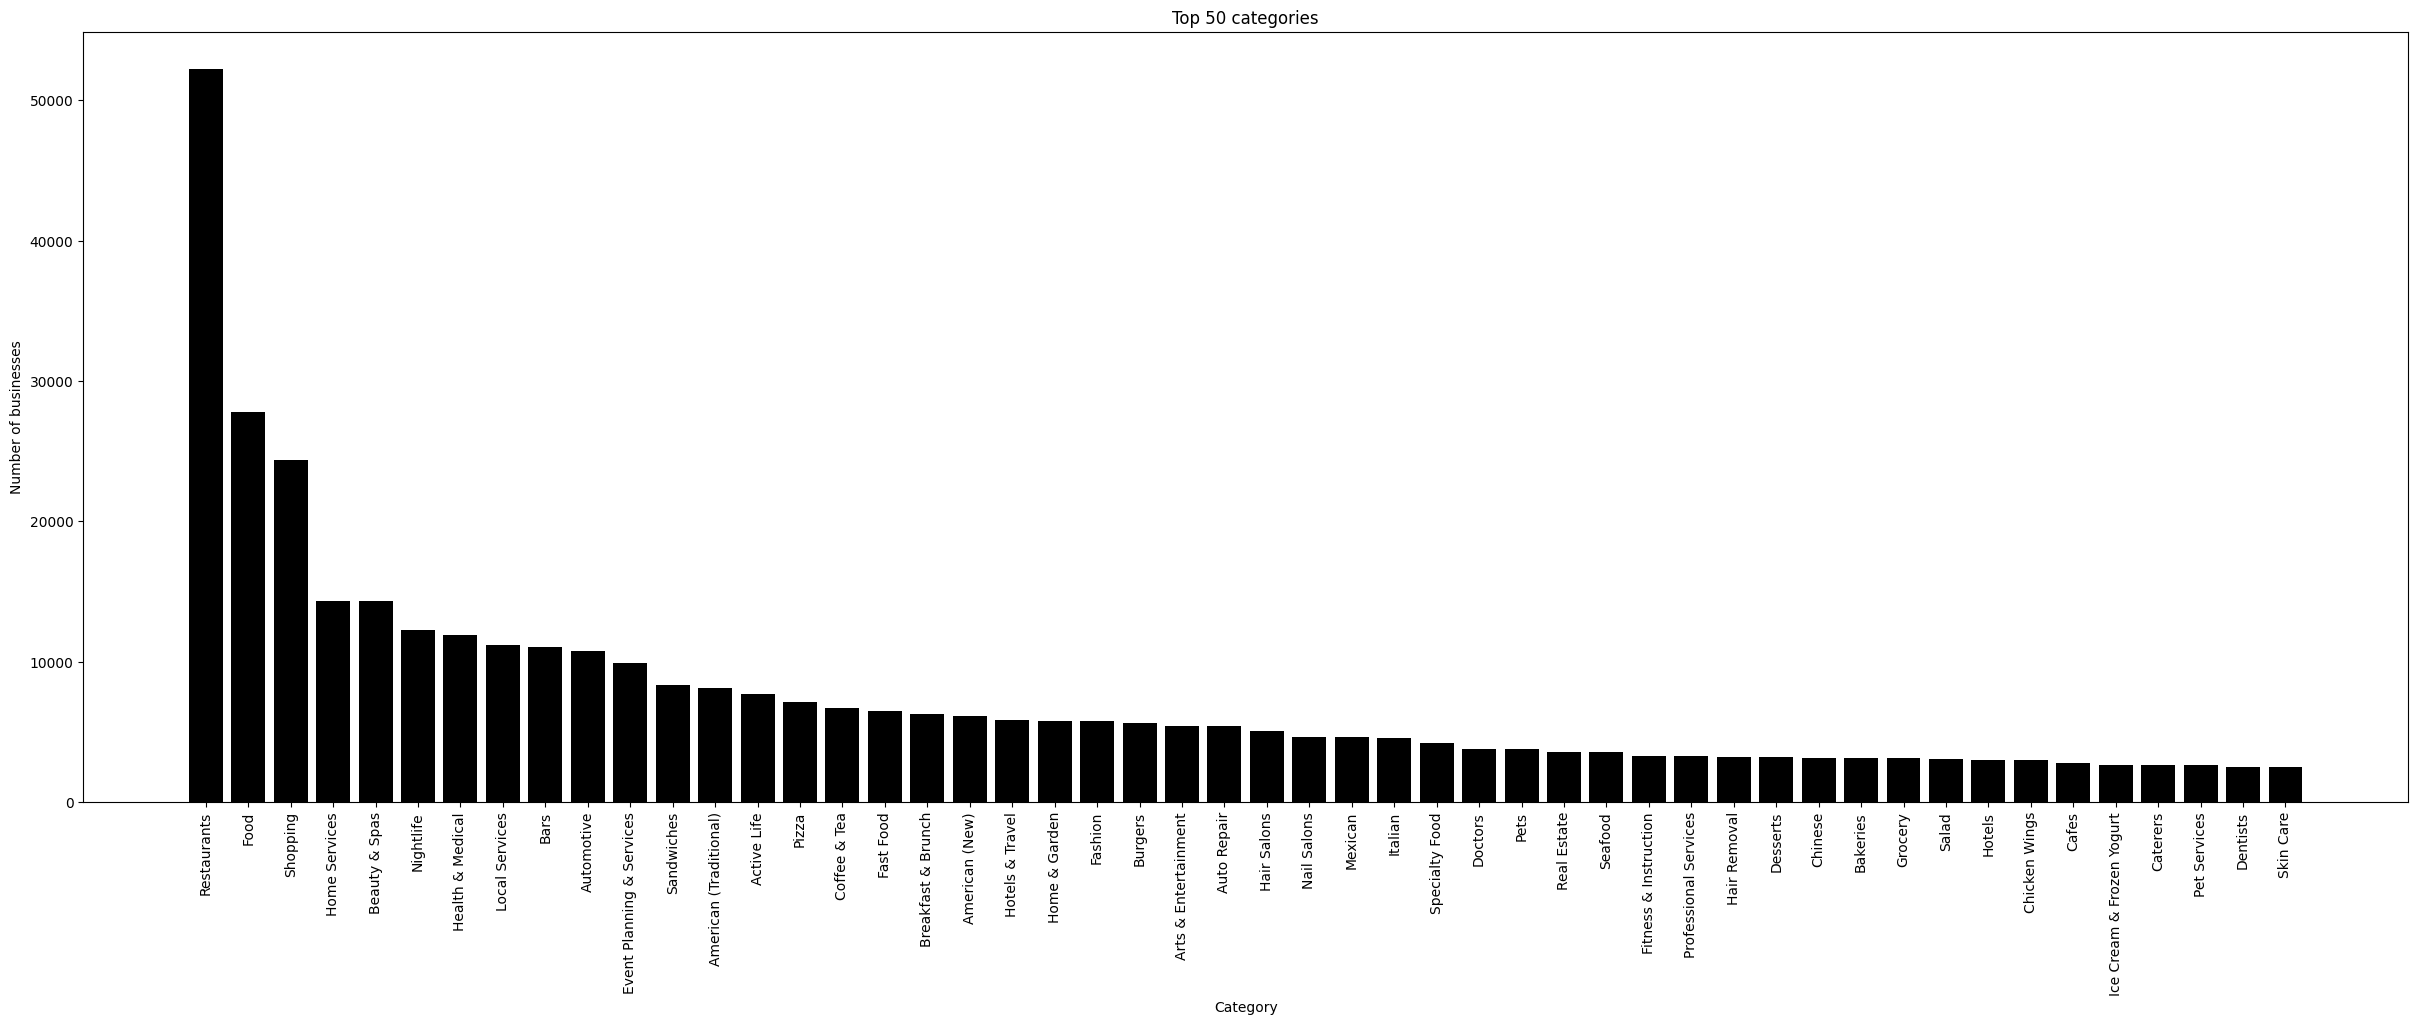

In [24]:
cat_freq = dict(sorted(cat_freq.items(), key=lambda item: item[1], reverse=True))
print("number of categories: ", len(cat_freq))
print("mean number of business in a category: ", np.mean(list(cat_freq.values())))
print("median number of business in a category: ", np.median(list(cat_freq.values())))
print("max number of business in a category: ", np.max(list(cat_freq.values())))
print("max category: ", list(cat_freq.keys())[np.argmax(list(cat_freq.values()))])
print("number of categories with more than 1000 business: ", len([i for i in cat_freq.values() if i > 1000]))
n = 50
print(f"the top {n} categories: ", list(cat_freq.keys())[:n])

cat_freq_top50 = dict(list(cat_freq.items())[:50])
plt.figure(figsize=(30, 10));
plt.bar(cat_freq_top50.keys(), cat_freq_top50.values(),color = "Black")
plt.xticks(rotation=90);
plt.title("Top 50 categories")
plt.xlabel("Category")
plt.ylabel("Number of businesses")
plt.title("Top 50 categories")


Some businesses can have additional information on their page, such as what kind of amenities they provide. Not all business have provided this information, therefore, see below to see the plot of the number of business have each "attribute". 

number of businesses with attributes:  150243 out of  150243
number of attributes:  39
mean number of business with an attribute:  30944.05128205128
median number of business with an attribute:  28953.0
max number of business with an attribute:  119765
most common attribute:  BusinessAcceptsCreditCards
Most popular attributes:  ['BusinessAcceptsCreditCards', 'BusinessParking', 'RestaurantsPriceRange2', 'BikeParking', 'RestaurantsTakeOut', 'WiFi', 'RestaurantsDelivery', 'GoodForKids', 'OutdoorSeating', 'RestaurantsReservations']


Text(0, 0.5, 'Number of businesses')

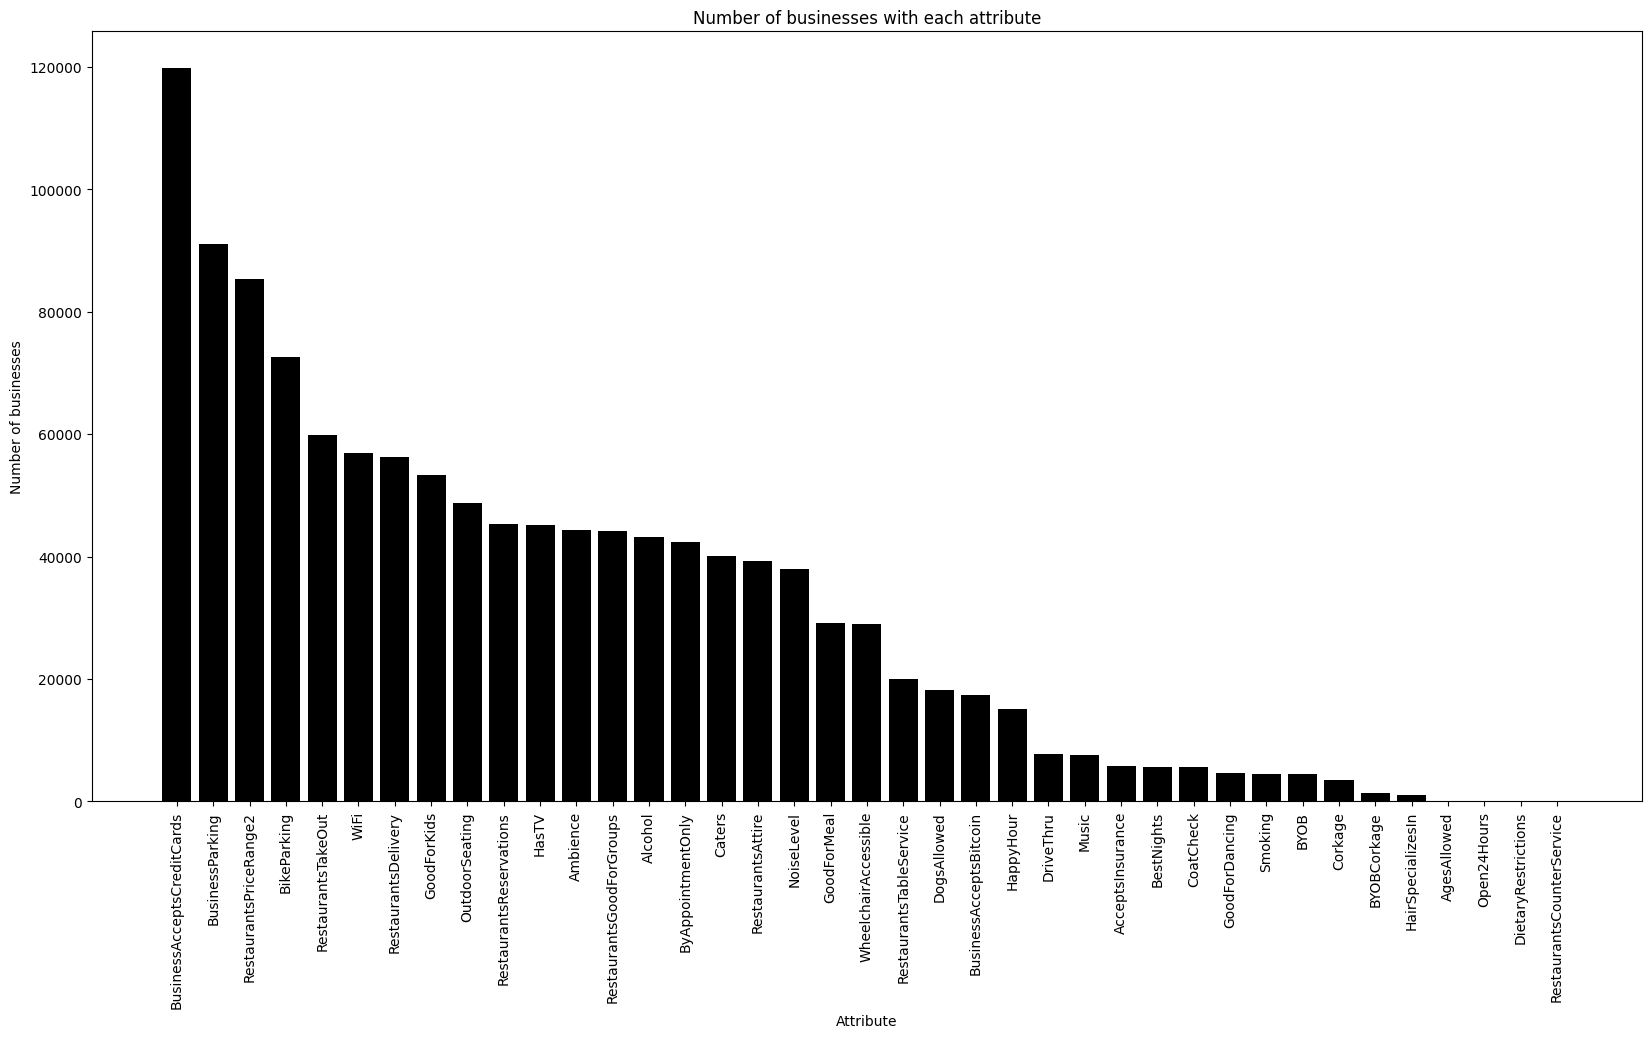

In [25]:
print("number of businesses with attributes: ", len(attribute_df), "out of ", BUSINESSES.shape[0])
attribute_freq = dict(sorted(attribute_freq.items(), key=lambda item: item[1], reverse=True))
print("number of attributes: ", len(attribute_freq))
print("mean number of business with an attribute: ", np.mean(list(attribute_freq.values())))

print("median number of business with an attribute: ", np.median(list(attribute_freq.values())))
print("max number of business with an attribute: ", np.max(list(attribute_freq.values())))
print("most common attribute: ", list(attribute_freq.keys())[0])
print("Most popular attributes: ", list(attribute_freq.keys())[:10])

plt.figure(figsize=(20, 10));
plt.bar(attribute_freq.keys(), attribute_freq.values(),color='Black')
plt.xticks(rotation=90);
plt.title("Number of businesses with each attribute")
plt.xlabel("Attribute")
plt.ylabel("Number of businesses")

## 3. Data Analysis 
- **Describe your data analysis and explain what you've learned about the dataset.**

One of the core points in our analysis is to determine if a restaurant was closed due to covid , the dataset provide information on whether a business is open or closed, but not when they closed. To estimate if the a business closed during covid, we filtered all restaurants that received a review or check-in at some point during covid, and if it is marked as closed in the dataset then we assume that it is closed due to the pandemic.  

Moreover, we decided to create a word cloud of all negative reviews to see if there are any differences in how customers reviewed open and closed restaurants. The terms shown in the word cloud were chosen using two different methods. First term counter were we count the number of reviews that mention a certain phrase and plot the highest count for each group (open and closed). This is done using `sklearn`'s `CountVectorizer` which also cleans the reviews from common "stop words" that don’t add meaningful information. The second method is done using TF-IDF, where we treat each review as a document, here we count the term frequency again the same as above, but here the score is penalized for terms that appear in many documents, since such terms are considered less distinctive or informative.  


Furthermore, using the new dataframe for attribute we analyzed the statistical difference between the two groups for each (non-string) attribute. this is done using Chi-square test. we will consider a p-value less than 0.05 to be significant. This mean that there is a corelation between that attribute and if they remained open.  

Finally, a bar plot of review count over time can be used to estimate the effects of some restrictions as they get added or removed.

# TODO last point and answer what you've learned about the dataset

In [8]:
print("=== Restaurant COVID Activity Summary ===")
print(f"Total restaurants in {red_city} and {blue_city}: {len(restaurants)}")
print(f"Restaurants active during COVID (Mar–Dec 2020): {len(restaurants_in_covid)}")
print(f" - Still open: {len(open_restaurants)} ({len(open_restaurants)/len(restaurants_in_covid)*100:.1f}%)")
print(f" - Closed: {len(closed_restaurants)} ({len(closed_restaurants)/len(restaurants_in_covid)*100:.1f}%)")

print("\n=== Reviews & Check-ins (COVID Period) ===")
print(f"Reviews for open restaurants: {len(open_reviews)}")
print(f"Reviews for closed restaurants: {len(closed_reviews)}")
print(f"Check-ins for open restaurants: {sum(len(d) for d in open_checkins['date_list'])}")
print(f"Check-ins for closed restaurants: {sum(len(d) for d in closed_checkins['date_list'])}")


=== Restaurant COVID Activity Summary ===
Total restaurants in Tampa and Philadelphia: 8812
Restaurants active during COVID (Mar–Dec 2020): 8812
 - Still open: 5489 (62.3%)
 - Closed: 3323 (37.7%)

=== Reviews & Check-ins (COVID Period) ===
Reviews for open restaurants: 41981
Reviews for closed restaurants: 2514
Check-ins for open restaurants: 1376546
Check-ins for closed restaurants: 420276


There are 2 Wordcloud. the first we use TF-IDF, which takes each review as document, counts the frequents terms, and if any frequent terms appears in a lot of documents, then the TF-IDF value become small. The word cloud shows highest TF-IDF terms. This is done for both reviews of open restaurants and closed restaurants. The second wordcloud shows the term frequency only, i.e. if terms are repeated in multiple reviews, then it shows. For both wordclouds we have remove mentions of "waiting" and time ("min"/"minutes") as the word cloud was overwhelmed by the different ways you can complain about waiting too long. Moreover, the "X" in the wordcloud refers to a digit, so "XX service charge" refers to a 2 digit number.  

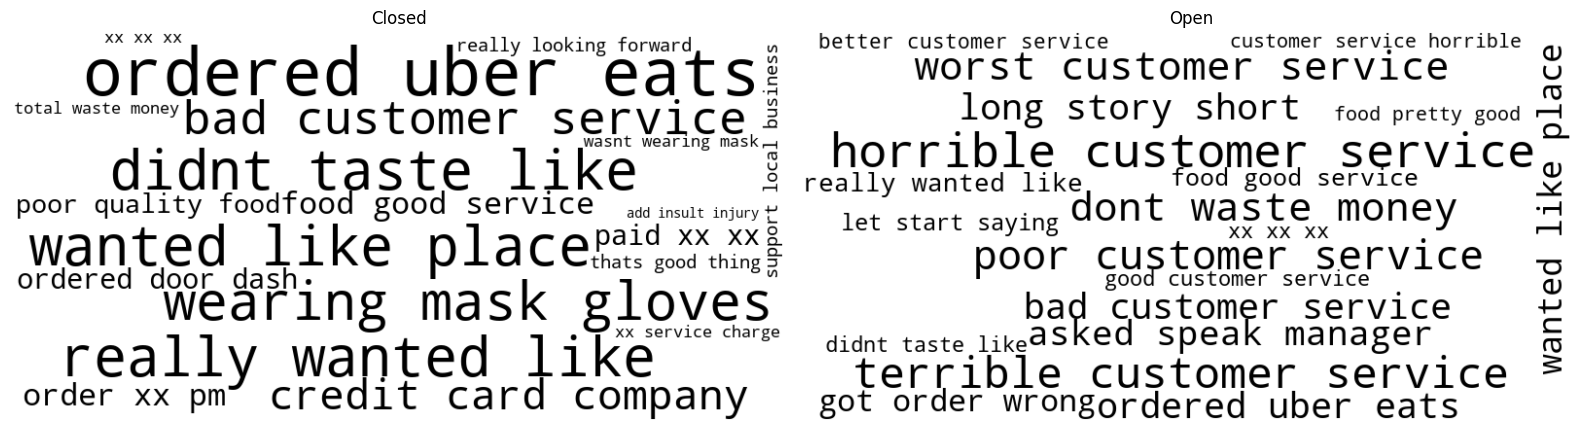

In [22]:
def create_wordcloud(opendf, closeddf, engram, ratings, words=20):
    def preprocess(df):
        texts = df[(df['text'].notna()) & (df["stars"] <= ratings)]['text'].tolist()
        texts = [re.sub(r'\d', 'x', t.replace("'", '').replace("-", '')) for t in texts]
        texts = [re.sub(r'\b(?:time|wait|waited|waiting|waits|min|mins|minutes|chicken)\b', '', text, flags=re.IGNORECASE) for text in texts]
        return texts

    open_text = preprocess(opendf)
    closed_text = preprocess(closeddf)

    vectorizer_open = TfidfVectorizer(stop_words='english', max_features=10000, lowercase=True,
                                      ngram_range=engram)
    tfidf_open = vectorizer_open.fit_transform(open_text)
    tfidf_open_mean = pd.DataFrame(tfidf_open.toarray(), columns=vectorizer_open.get_feature_names_out()).astype(bool).sum()

    vectorizer_closed = TfidfVectorizer(stop_words='english', max_features=10000, lowercase=True,
                                        ngram_range=engram)
    tfidf_closed = vectorizer_closed.fit_transform(closed_text)
    tfidf_closed_mean = pd.DataFrame(tfidf_closed.toarray(), columns=vectorizer_closed.get_feature_names_out()).astype(bool).sum()

    wordcloud_open = WordCloud(width=800, height=400, max_words=words, background_color='white',color_func=lambda *args, **kwargs: "black")\
                     .generate_from_frequencies(tfidf_open_mean)
    wordcloud_closed = WordCloud(width=800, height=400, max_words=words, background_color='white',color_func=lambda *args, **kwargs: "black")\
                       .generate_from_frequencies(tfidf_closed_mean)

    fig, ax = plt.subplots(1, 2, figsize=(16, 8))
    ax[0].imshow(wordcloud_closed, interpolation='bilinear')
    ax[0].set_title("Closed")
    ax[0].axis("off")


    ax[1].imshow(wordcloud_open, interpolation='bilinear')
    ax[1].set_title("Open")
    ax[1].axis("off")

    plt.tight_layout()
create_wordcloud(open_reviews, closed_reviews, engram=(3,3), ratings=2, words=20)
plt.savefig("../assets/wordcloudtfidf.png")


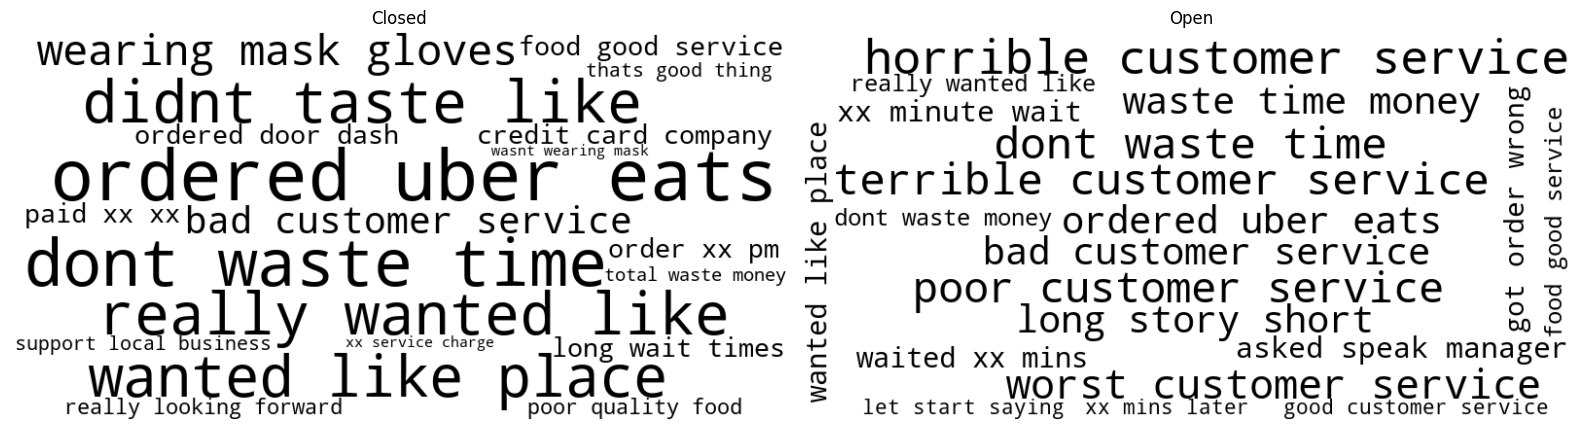

In [15]:
def create_wordcloud_count(opendf, closeddf, engram, ratings, words=20):
    def preprocess(df):
        texts = df[(df['text'].notna()) & (df["stars"] <= ratings)]['text'].tolist()
        texts = [re.sub(r'\d', 'x', t.replace("'", '').replace("-", '')) for t in texts]
        texts = [re.sub(r'\b(?:min|minutes)\b', '', text, flags=re.IGNORECASE) for text in texts]
        return texts

    open_text = preprocess(opendf)
    closed_text = preprocess(closeddf)

    vectorizer_open = CountVectorizer(stop_words='english', max_features=10000, lowercase=True,
                                      ngram_range=engram)
    count_open = vectorizer_open.fit_transform(open_text)
    count_open_sum = pd.DataFrame(count_open.toarray(), columns=vectorizer_open.get_feature_names_out()).astype(bool).sum()

    vectorizer_closed = CountVectorizer(stop_words='english', max_features=10000, lowercase=True,
                                        ngram_range=engram)
    count_closed = vectorizer_closed.fit_transform(closed_text)
    count_closed_sum = pd.DataFrame(count_closed.toarray(), columns=vectorizer_closed.get_feature_names_out()).astype(bool).sum()

    wordcloud_open = WordCloud(width=800, height=400, max_words=words, background_color='white',color_func=lambda *args, **kwargs: "black")\
                     .generate_from_frequencies(count_open_sum)
    wordcloud_closed = WordCloud(width=800, height=400, max_words=words, background_color='white',color_func=lambda *args, **kwargs: "black")\
                       .generate_from_frequencies(count_closed_sum)

    fig, ax = plt.subplots(1, 2, figsize=(16, 8))
    ax[0].imshow(wordcloud_closed, interpolation='bilinear')
    ax[0].set_title("Closed")
    ax[0].axis("off")

    ax[1].imshow(wordcloud_open, interpolation='bilinear')
    ax[1].set_title("Open")
    ax[1].axis("off")

    plt.tight_layout()
    plt.savefig("../assets/wordcloudtermfreq.png")

create_wordcloud_count(open_reviews, closed_reviews, engram=(3,3), ratings=2, words=20)


Attribute Statistics between open and closed restaurants 

Here we print for each attribute we calculate the, p-value, % open has it, % closed has it, mean open, mean closed, count open and count closed. This is done to see if there is any attributes that are significantly different between open and closed restaurants.   

In [11]:
results = []
for col in attribute_df.columns:
    try:
        if attribute_df[col].nunique() > 3:
            continue
    except TypeError:
        continue

    open_vals = open_attributes[col]
    closed_vals = closed_attributes[col]

    values = pd.concat([open_vals, closed_vals])
    groups = ['open'] * len(open_vals) + ['closed'] * len(closed_vals)

    table = pd.crosstab(values, groups)
    if table.shape[0] < 2 or table.shape[1] < 2:
        continue

    chi2, p, _, _ = chi2_contingency(table)
    results.append((col, p))

results = sorted(results, key=lambda x: x[1])
print("number of open restaurants: ", len(open_attributes))
print("number of closed restaurants: ", len(closed_attributes))

print("\n=== Chi-Squared Test Results ===")
print(f"\n{'Attribute':<30}{'p-value':<10}{'% open has it':<15}{'% closed has it':<17}"
      f"{'mean open':<15}{'mean closed':<15}{'count open':<15}{'count closed':<15}"
      f"{'None open':<15}{'None closed'}")

for col, p in results:
    open_total = len(open_attributes)
    closed_total = len(closed_attributes)

    open_clean = open_attributes[col]
    closed_clean = closed_attributes[col]

    open_pct = round(open_clean.notna().sum() / open_total * 100, 2)
    closed_pct = round(closed_clean.notna().sum() / closed_total * 100, 2)

    open_count = open_clean.count()
    closed_count = closed_clean.count()

    open_none = open_clean.isna().sum() + (open_clean == 'None').sum()
    closed_none = closed_clean.isna().sum() + (closed_clean == 'None').sum()

    try:
        open_mean = round(pd.to_numeric(open_clean, errors='coerce').mean(), 2)
        closed_mean = round(pd.to_numeric(closed_clean, errors='coerce').mean(), 2)
    except:
        open_mean = closed_mean = 'n/a'

    print(f"{col:<30}{p:<10.3f}{str(open_pct) + '%':<15}{str(closed_pct) + '%':<17}"
          f"{str(open_mean):<15}{str(closed_mean):<15}{open_count:<15}{closed_count:<15}"
          f"{open_none:<15}{closed_none}")


number of open restaurants:  5489
number of closed restaurants:  3323

=== Chi-Squared Test Results ===

Attribute                     p-value   % open has it  % closed has it  mean open      mean closed    count open     count closed   None open      None closed
RestaurantsDelivery           0.000     87.12%         83.6%            0.78           0.47           4782           2778           707            545
HasTV                         0.000     78.65%         79.33%           0.78           0.6            4317           2636           1172           687
HappyHour                     0.000     29.39%         22.42%           0.59           0.82           1613           745            3876           2578
RestaurantsReservations       0.000     78.03%         86.16%           0.31           0.41           4283           2863           1206           460
DriveThru                     0.000     9.95%          3.37%            0.51           0.14           546            112           

The following will keep track how the percentage of reviews that mention terms that deal with contactless service.  

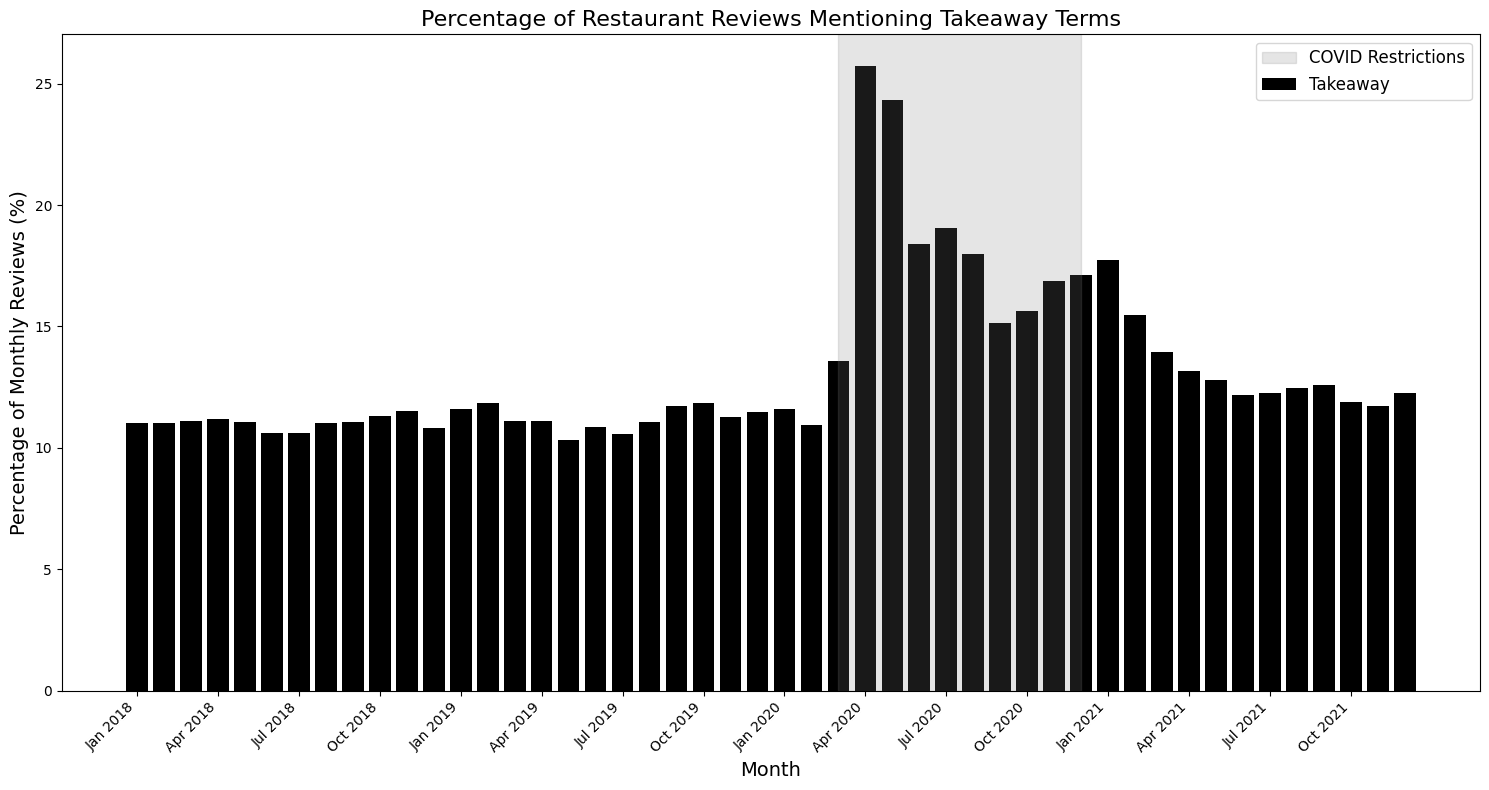

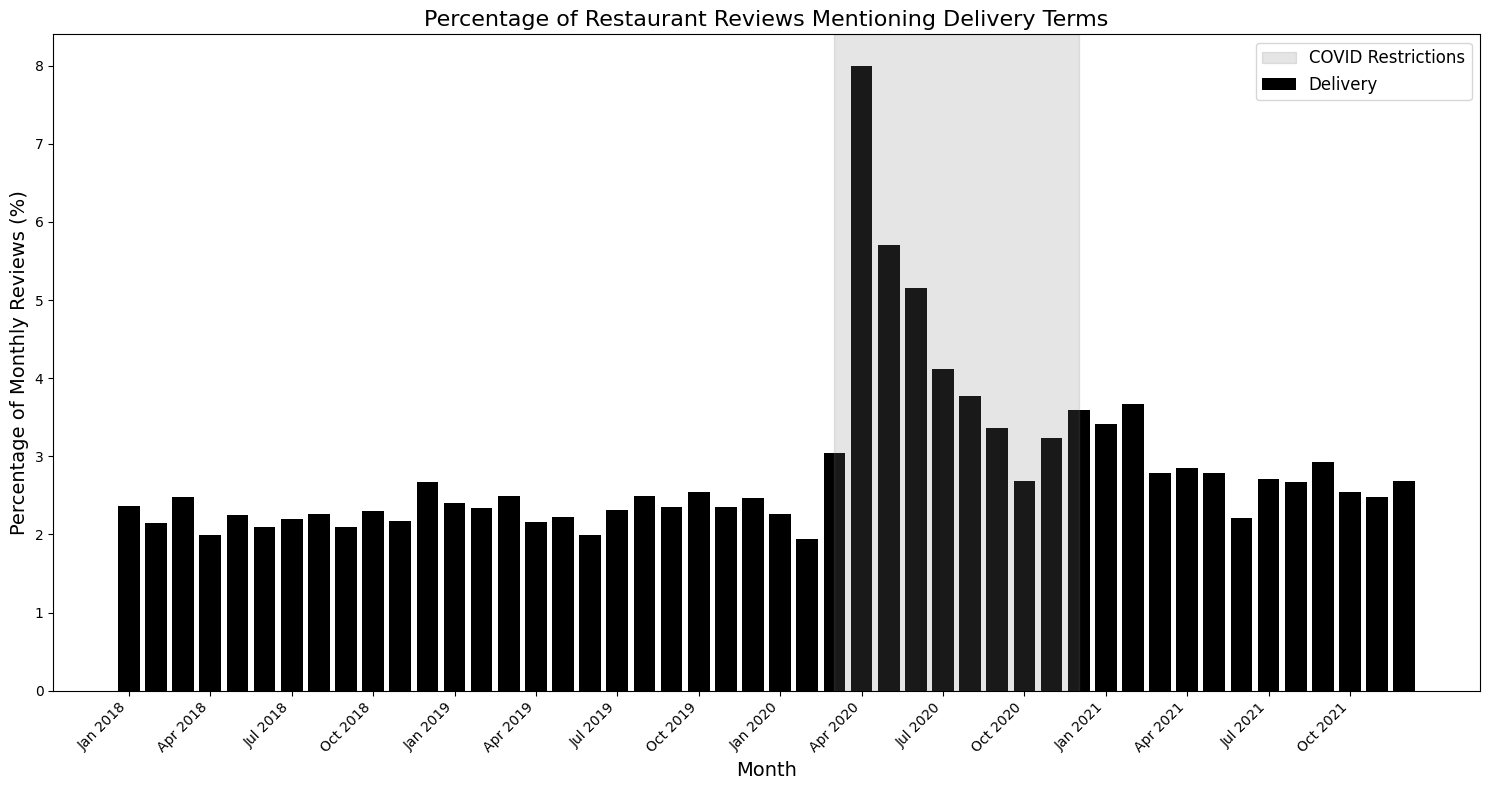

In [32]:
takeaway_terms = [
    "takeaway", "take-away", "take away", "take-out", "take out", "takeout",
    "to go", "togo", "pickup", "pick-up", "pick up", "take-home", "take home",
    "carryout", "carry-out", "carry out", "collected food", "collection",
    "order to go", "grab and go", "curbside", "curbside pickup"
]

delivery_companies = [
    "UberEats", "Uber Eats", "DoorDash", "Door Dash", "Grubhub", "Grub Hub",
    "Postmates", "Seamless", "Deliveroo", "Just Eat", "Instacart", "Caviar",
    "Delivery.com", "Foodler", "ChowNow", "Slice", "goPuff", "Bite Squad",
    "Eat Street", "EatStreet", "Waitr", "Zomato"
]

def plot_term_trends_proportion(term_list_name, terms, start_year=2018, end_year=2021):
    filtered_reviews = restaurants_reviews[
        (restaurants_reviews['date'] >= f'{start_year}-01-01')
    ].copy()
    filtered_reviews['month'] = filtered_reviews['date'].dt.to_period('M').dt.to_timestamp()
    pattern = '|'.join(r'\b' + re.escape(term.lower()) + r'\b' for term in terms)
    filtered_reviews[f'has_{term_list_name}'] = filtered_reviews['text'].str.lower().str.contains(
        pattern, regex=True, na=False)
    monthly_mentioning = filtered_reviews[filtered_reviews[f'has_{term_list_name}']].groupby('month').size()
    monthly_total = filtered_reviews.groupby('month').size()

    date_range = pd.date_range(start=f'{start_year}-01-01', end=f'{end_year}-12-01', freq='MS')
    monthly_data = pd.DataFrame(index=date_range)
    monthly_data['mentioning'] = monthly_mentioning
    monthly_data['total'] = monthly_total
    monthly_data = monthly_data.fillna(0)
    
    monthly_data['proportion'] = (monthly_data['mentioning'] / monthly_data['total']) * 100
    monthly_data['proportion'] = monthly_data['proportion'].fillna(0)
    
    # Plot
    plt.figure(figsize=(15, 8))
    x = np.arange(len(monthly_data.index))
    plt.bar(x, monthly_data['proportion'], 
           label=term_list_name, color='Black')

    covid_start_idx = np.where(monthly_data.index == pd.to_datetime('2020-03-01'))[0][0]
    covid_end_idx = np.where(monthly_data.index == pd.to_datetime('2020-12-01'))[0][0]
    plt.axvspan(covid_start_idx, covid_end_idx, color='gray', alpha=0.2, label='COVID Restrictions')
    
    step = 3  
    plt.xticks(x[::step], [d.strftime('%b %Y') for d in monthly_data.index[::step]], rotation=45, ha='right')
    
    plt.title(f'Percentage of Restaurant Reviews Mentioning {term_list_name} Terms', fontsize=16)
    plt.xlabel('Month', fontsize=14)
    plt.ylabel('Percentage of Monthly Reviews (%)', fontsize=14)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.legend(fontsize=12)
    plt.grid(False)
    plt.tight_layout()
    path = f"../assets/{term_list_name}.png"
    plt.savefig(path)
    
    return plt.show()

plot_term_trends_proportion('Takeaway', takeaway_terms)
plot_term_trends_proportion('Delivery', delivery_companies)

## 4. Genre. Which genre of data story did you use?

The genre used in this paper is Magazine style, since we wanted to combine text and graphics to be similar to an article.

- **Which tools did you use from each of the 3 categories of Visual Narrative (Figure 7 in Segal and Heer)? Why?**

    - **Consistent Visual Platform**: All plots and tables use the same layout, fonts, and color conventions. For example, Tampa vs Philly businesses are always red vs blue. This consistency helps the reader focus on the information, not on figuring out how to read the visuals.
  
    - **Feature Distinction Highlighting**: We use color to visually distinguish open vs closed or cities in the bar plots. Moreover, the size of the phrases in the word cloud emphasizes the importance.
  
    - **Transition Guidance**: It is difficult to apply to magazine style, even in the paper (Segal and Heer) does not give many examples. However, it can be argued that we use **object continuity**, since the same types of visuals recur across sections. This reuse of familiar visual objects supports smooth transitions.

- **Which tools did you use from each of the 3 categories of Narrative Structure (Figure 7 in Segal and Heer)? Why?**

    - **Linear Ordering**: The paper goes through the data as a whole then slowly narrows the scope.
  
    - **Selection Interactivity**: We incorporate interactive features where users can select different data to display based on categories. This allows users to focus on specific subsets of the data and explore how different groups were affected during the pandemic.
  
    - **Summary Messaging**: At the end, we have written a comprehensive summary of the analysis done in this paper and stated the findings and possible research questions to further investigate.


## 5. Visualizations.

- **Explain the visualizations you've chosen.**  
First, it is important to understand the spread of data since it is a subset that is dependent on location, so showing business count and review count per city and state is essential for exploration. Moreover, to capture the effect of COVID on businesses, time based plots are necessary, became they show trends before, during, and after the pandemic. Finally, word clouds provide summary of review themes.  

TODO talk about the maps and bokeh.

- **Why are they right for the story you want to tell?**  

The goal is to uncover what helped businesses survive the pandemic. Time-based plots are essential to show change across the pandemic timeline. Word clouds distill review content, offering a intuitive view into how customer feedback might reflect business outcomes. These choices support both the analytical goals and the narrative structure, giving readers context, evidence, and interpretation in a visually cohesive way.

# TODO again talk about the other plots

Below are 2 plots, one that shows the number of reviews received for each month per city. Notice how the number of reviews in Philly is much larger, that is because Philly is a bigger city with more people and restaurants. as of 2023 Philly has a population of 1.55 million and Tampa has a population of 403,000. However, if we average out the number of reviews per restaurant, see second plot, the numbers seem pretty similar. Furthermore, we can see a big drop once restrictions starts in march 2020.  

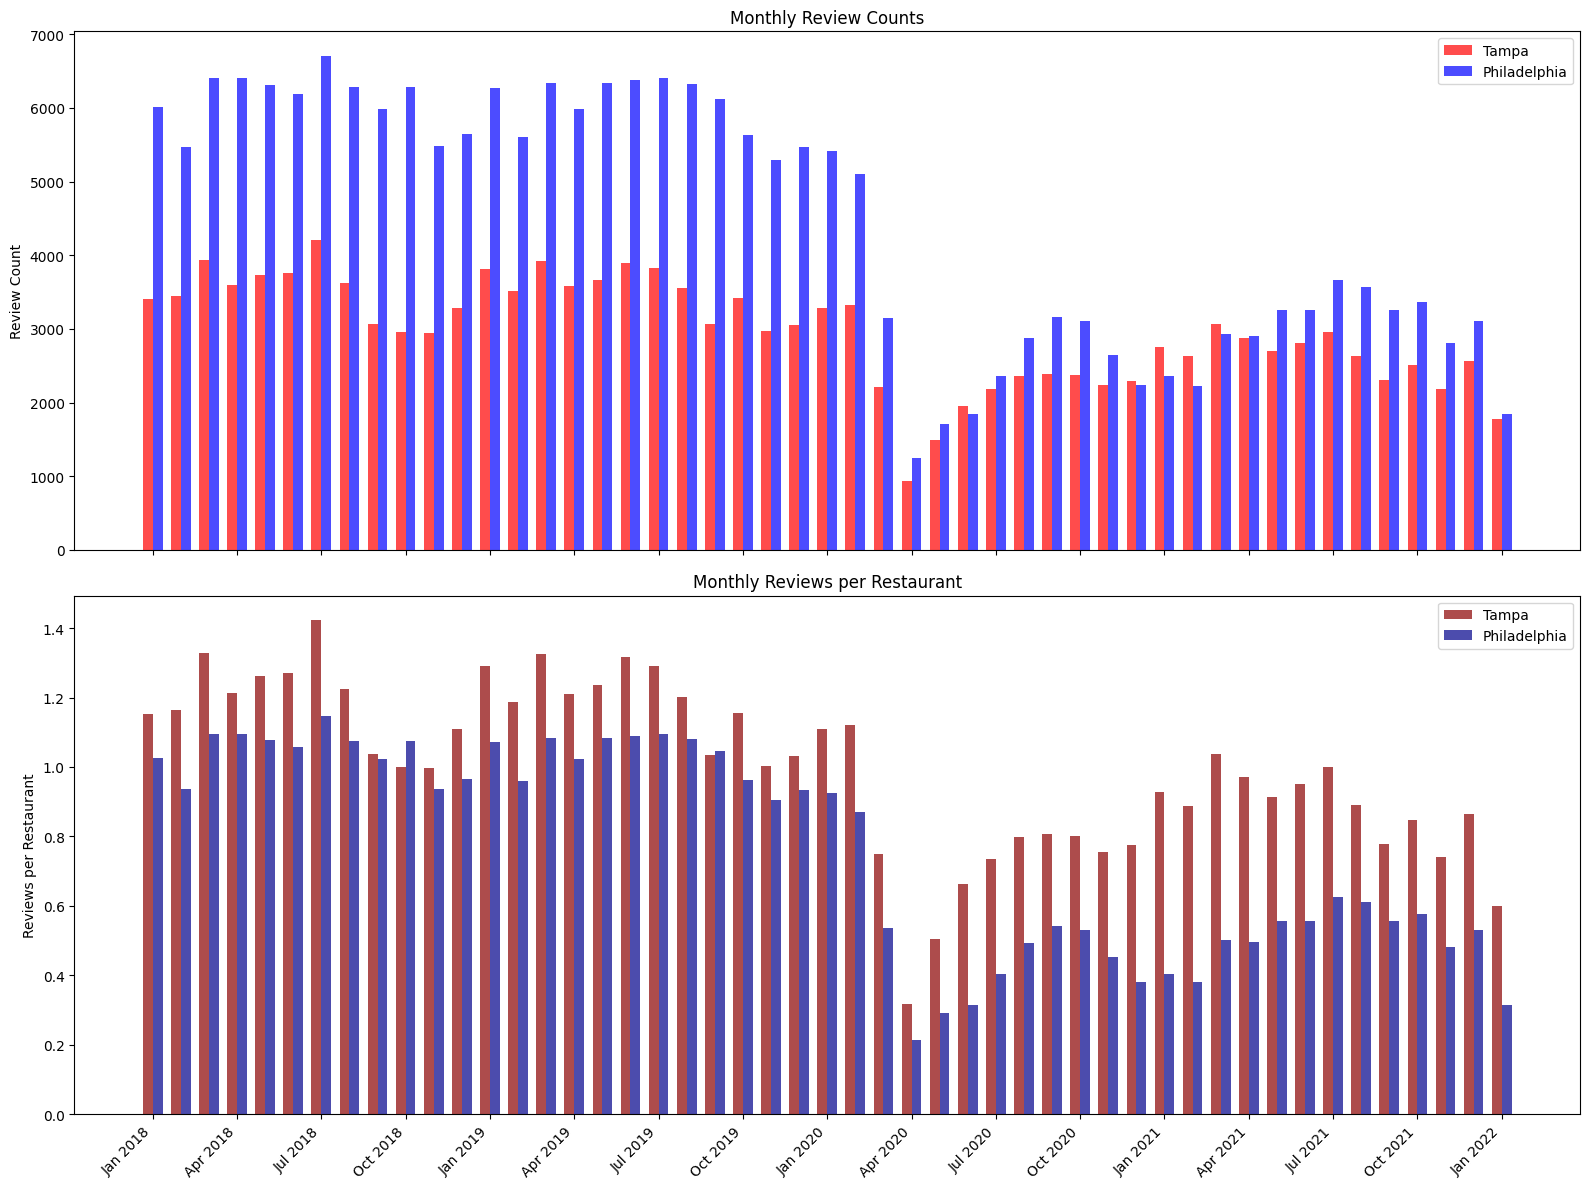

In [ ]:
data_to_plot = reviews[
    (reviews['date'].dt.year >= 2018) & (reviews['date'].dt.year <= 2025)
].copy()

data_to_plot = data_to_plot[data_to_plot['business_id'].isin(restaurant_ids)]

data_to_plot['date'] = data_to_plot['date'].dt.to_period('M').dt.to_timestamp()
monthly_counts = data_to_plot.groupby(['date', 'city']).size().reset_index(name='review_count')

restaurants_in_red = len(restaurants[restaurants['business_id'].isin(red_business_ids)])
restaurants_in_blue = len(restaurants[restaurants['business_id'].isin(blue_business_ids)])

monthly_counts['review_per_rest'] = monthly_counts.apply(
    lambda row: row['review_count'] / restaurants_in_red if row['city'] == red_city
    else row['review_count'] / restaurants_in_blue if row['city'] == blue_city else 0,
    axis=1
)

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(16, 12), sharex=True)
dates = sorted(monthly_counts['date'].unique())
x = np.arange(len(dates))
width = 0.35

def get_series(city, col):
    city_data = monthly_counts[monthly_counts['city'] == city].set_index('date')
    return [city_data[col].get(d, 0) for d in dates]

ax1.bar(x - width/2, get_series(red_city, 'review_count'), width, label=red_city, color='red', alpha=0.7)
ax1.bar(x + width/2, get_series(blue_city, 'review_count'), width, label=blue_city, color='blue', alpha=0.7)
ax1.set_title('Monthly Review Counts')
ax1.set_ylabel('Review Count')
ax1.legend()
ax1.grid(False)

ax2.bar(x - width/2, get_series(red_city, 'review_per_rest'), width, label=red_city, color='darkred', alpha=0.7)
ax2.bar(x + width/2, get_series(blue_city, 'review_per_rest'), width, label=blue_city, color='darkblue', alpha=0.7)
ax2.set_title('Monthly Reviews per Restaurant')
ax2.set_ylabel('Reviews per Restaurant')
ax2.legend()

# X-axis
ax2.set_xticks(x[::3])
ax2.set_xticklabels([d.strftime('%b %Y') for d in dates][::3], rotation=45, ha='right')
ax2.grid(False)
plt.tight_layout()
plt.show()


The following plots shows similar information to the previous 2 plots, except we compares all restaurants with all shopping businesses. Here we can see that people review restaurants way more often than they do for "shopping" businesses, even though, "shopping" is third most popular category after "food". 

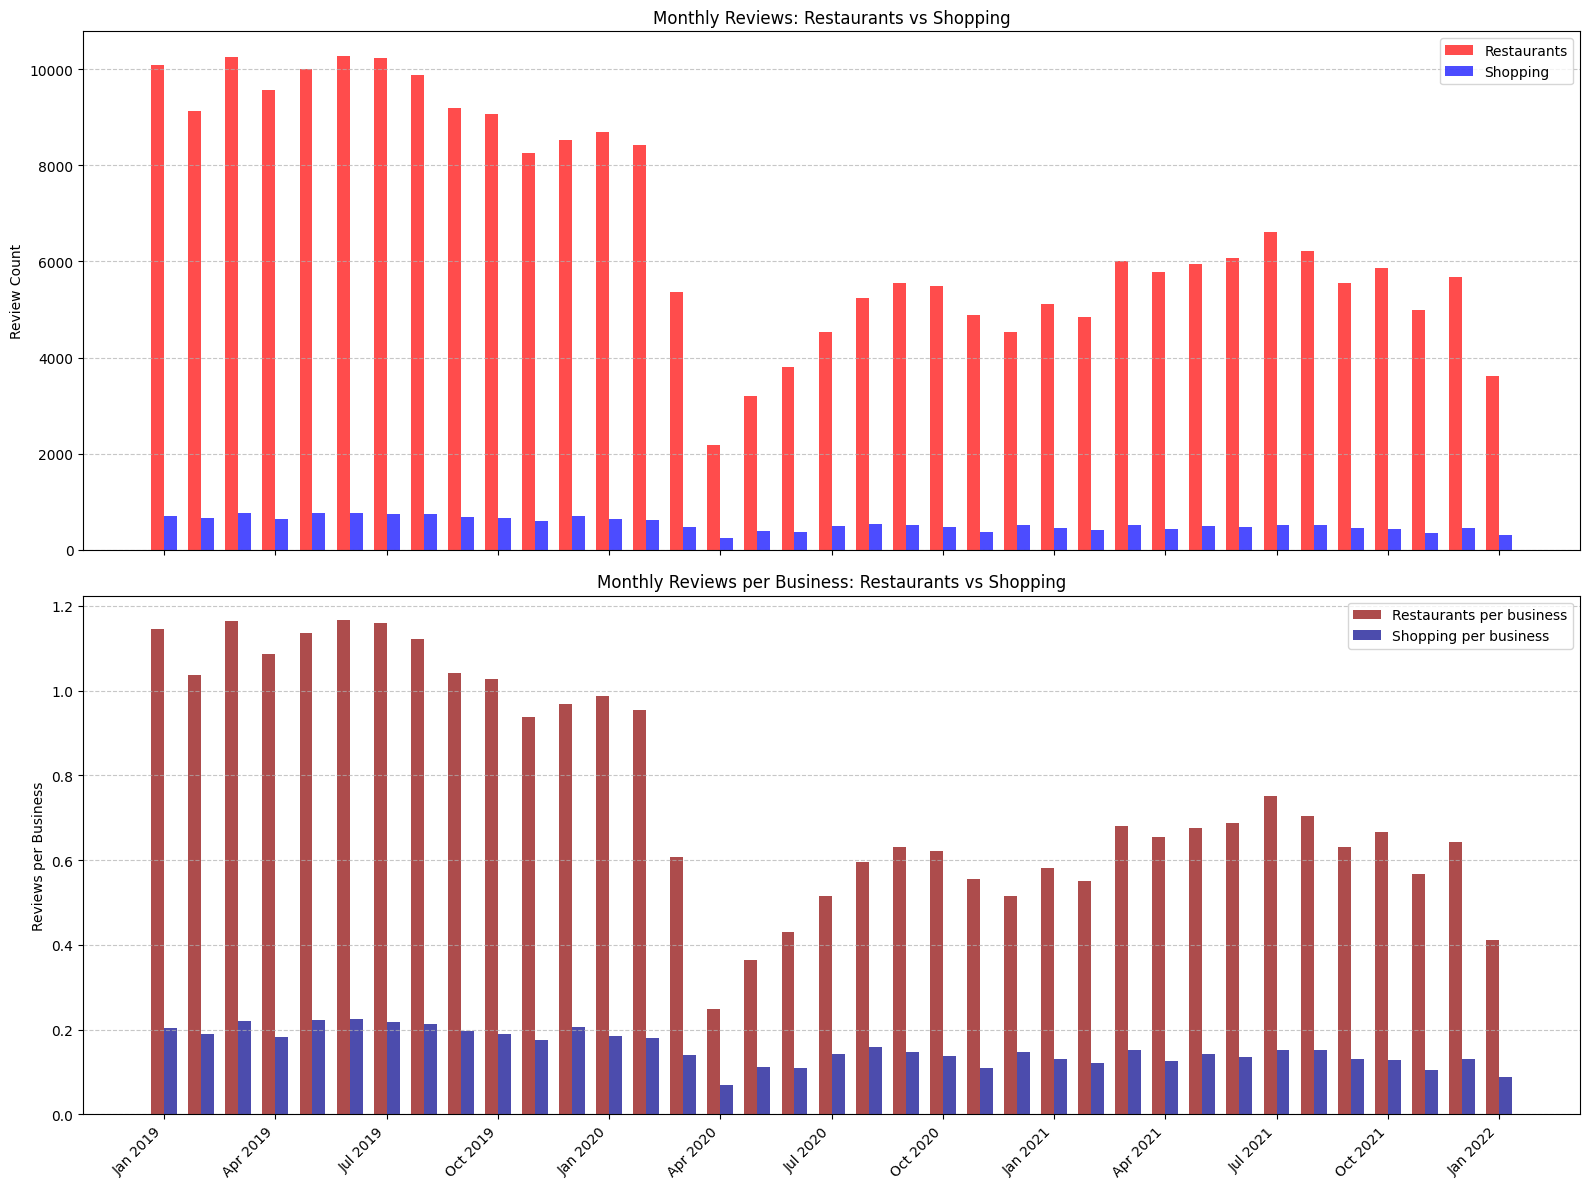

In [ ]:
cat1 = "Restaurants"
cat2 = "Shopping"
start, end = "2019-01-01", "2025-01-01"

filtered = reviews[(reviews['date'] >= start) & (reviews['date'] <= end)].copy()
filtered = filtered[filtered['business_id'].isin(restaurant_ids + shopping_ids)]
filtered["category"] = filtered["business_id"].apply(lambda x: cat1 if x in restaurant_ids else cat2)
filtered['date'] = filtered['date'].values.astype('datetime64[M]')  # month precision

monthly = filtered.groupby(['date', 'category']).size().unstack(fill_value=0).reset_index()
monthly['review_per_rest'] = monthly[cat1] / len(restaurant_ids)
monthly['review_per_shop'] = monthly[cat2] / len(shopping_ids)

x = np.arange(len(monthly))
width = 0.35

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(16, 12), sharex=True)

ax1.bar(x - width/2, monthly[cat1], width, label=cat1, color='red', alpha=0.7)
ax1.bar(x + width/2, monthly[cat2], width, label=cat2, color='blue', alpha=0.7)
ax1.set_ylabel("Review Count")
ax1.set_title(f"Monthly Reviews: {cat1} vs {cat2}")
ax1.legend()
ax1.grid(False)

ax2.bar(x - width/2, monthly['review_per_rest'], width, label=f"{cat1} per business", color='darkred', alpha=0.7)
ax2.bar(x + width/2, monthly['review_per_shop'], width, label=f"{cat2} per business", color='darkblue', alpha=0.7)
ax2.set_ylabel("Reviews per Business")
ax2.set_title(f"Monthly Reviews per Business: {cat1} vs {cat2}")
ax2.set_xticks(x[::3])
ax2.set_xticklabels(monthly['date'].dt.strftime('%b %Y')[::3], rotation=45, ha='right')
ax2.legend()
ax2.grid(False)

plt.tight_layout()
plt.show()


## 6. Discussion. Think critically about your creation

- **What went well?**
    
The choice of Yelp data was appropriate, it offered detailed, real world business activity and public sentiment. The dataset allowed us to estimate the timing of business closures using review and check-in activity, which gave us a reasonable proxy for when a business likely shut down. The way we examined business by comparing attributes distributions and statistical significance, and comparing reviews helped surface patterns tied to survival, without overstating trends.

- **What is still missing? What could be improved? Why?**

The biggest limitation is causation, we can observe patterns and corelation but can't confirm why businesses closed. Another key limitation is the inability to isolate the effects of COVID-19 restrictions across regions. While the inclusion of both a red and blue cities was intentional, using review count as a metric for success was not enough to show significant differences. There’s also a data imbalance—non-restaurant business categories were underrepresented, which limited generalization outside food-related industries.

## 7. Contributions. Who did what?
- You should write (just briefly) which group member was the main responsible for which elements of the assignment. (I want you guys to understand every part of the assignment, but usually there is someone who took lead role on certain portions of the work. That's what you should explain).
- It is not OK simply to write "All group members contributed equally".


## 8. References
- Make sure that you use references when they're needed and follow academic standards.